In [62]:
import ee
import geopandas as gpd
import fiona
import matplotlib.pyplot as plt
import pandas as pd
import rasterio as rio
from rasterio.plot import show

from src.data import mtbs
from src.visualization import ee_viz
from src.data import gedi_loader
from src.data import rio_utils
from src.data import sample_raster
from src.data.fire_perimeters import FirePerimeters, FirePerimetersDB, Fire, match_gedi_to_raster


import seaborn as sns
sns.set_theme()

import importlib
importlib.reload(mtbs)
importlib.reload(ee_viz)
importlib.reload(sample_raster)
importlib.reload(fire_perimeters)

<module 'src.data.fire_perimeters' from '/home/jk871/fire-regen/src/data/fire_perimeters.py'>

### Initialize Earth Engine

In [ ]:
ee.Authenticate()

In [3]:
ee.Initialize()

### Get regions of interest

In [4]:
# Fetch simplified regions of interest - to avoid processing problems with really complicated shapes.
seki = gpd.read_file("../../data/shapefiles/seki_convex_hull.shp")
sierras = gpd.read_file("../../data/shapefiles/sierras_convex_hull.shp")

### Get Fire Perimeters

In [22]:
firep_db = FirePerimetersDB('../../data/fire_perimeters.gdb/')

In [23]:
sierra_firep = FirePerimeters(firep_db).filter_for_years(['2020', '2021']).filter_within_geometry(sierras)
print(f'Total number of fires in the Sierras in 2020 and 2021 is {sierra_firep.count()}')

Total number of fires in the Sierras in 2020 and 2021 is 248


In [24]:
sierra_firep.get_largest_fires(20)

21674               DIXIE
241                 CREEK
236         NORTH COMPLEX
21594              CALDOR
237                CASTLE
21575               SUGAR
21645               WINDY
21424         KNP Complex
340      W-5 COLD SPRINGS
21660            TAMARACK
231              LOYALTON
232                 SHEEP
336                 SLINK
21623              FRENCH
424                  GOLD
325         MOUNTAIN VIEW
318              BACCARAT
21648               RIVER
295                   HOG
21595             WALKERS
Name: FIRE_NAME, dtype: object

## Dixie Fire

Cannot analyze it because we don't have MTBS data on it. We could derive our own NBRs, but that can come later.

## Creek Fire

In [25]:
creek = sierra_firep.get_fire('CREEK')

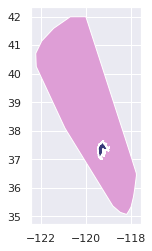

In [46]:
creek.overlay_fire_map(sierras)

In [48]:
creek.get().geometry.explore()

In [26]:
creek.load_gedi(load_buffer=True)

2023-05-05 16:28:56,227 INFO: Loading Level 4a GEDI shots for period 2019-2023 in this geometry [in get_gedi_shots at /home/jk871/fire-regen/src/data/gedi_loader.py:20]


/home/jk871/fire-regen/src/data/gedi_database.py:77: SAWarning: Did not recognize type 'geometry' of column 'geometry'
  col["name"] for col in self.inspector.get_columns(table_name)
/home/jk871/fire-regen/src/data/gedi_database.py:77: SAWarning: Did not recognize type 'geometry' of column 'geom_4326'
  col["name"] for col in self.inspector.get_columns(table_name)


2023-05-05 16:29:27,808 INFO: Number of GEDI shots found: 110015 [in get_gedi_shots at /home/jk871/fire-regen/src/data/gedi_loader.py:58]
2023-05-05 16:29:27,880 INFO: Loading Level 4a GEDI shots for period 2019-2023 in this geometry [in get_gedi_shots at /home/jk871/fire-regen/src/data/gedi_loader.py:20]


/home/jk871/fire-regen/src/data/gedi_database.py:77: SAWarning: Did not recognize type 'geometry' of column 'geometry'
  col["name"] for col in self.inspector.get_columns(table_name)
/home/jk871/fire-regen/src/data/gedi_database.py:77: SAWarning: Did not recognize type 'geometry' of column 'geom_4326'
  col["name"] for col in self.inspector.get_columns(table_name)


2023-05-05 16:30:21,285 INFO: Number of GEDI shots found: 162130 [in get_gedi_shots at /home/jk871/fire-regen/src/data/gedi_loader.py:58]


### Get CREEK severity rasters

In [97]:
# Reproject all the tiff files to 'EPSG:4326'
# TODO: Check the size of each raster cell after the projection.
rio_utils.reproject_raster('/maps/fire-regen/data/rasters/CREEK/ca3720111927220200905_20200827_20210830_dnbr6.tif', '/maps/fire-regen/data/rasters/CREEK/creek_dnbr6.tiff')
rio_utils.reproject_raster('/maps/fire-regen/data/rasters/CREEK/ca3720111927220200905_20200827_20210830_dnbr.tif', '/maps/fire-regen/data/rasters/CREEK/creek_dnbr.tiff')
rio_utils.reproject_raster('/maps/fire-regen/data/rasters/CREEK/ca3720111927220200905_20200827_20210830_rdnbr.tif', '/maps/fire-regen/data/rasters/CREEK/creek_rdnbr.tiff')

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 2686, 'height': 2504, 'count': 1, 'crs': 'EPSG:4326', 'transform': Affine(0.00031425399622582754, 0.0, -119.63775069709324,
       0.0, -0.00031425399622582754, 37.718303603272204)}
1


In [27]:
gedi_dnbr6 = creek.sample_raster('/maps/fire-regen/data/rasters/CREEK/creek_dnbr6.tiff', 3, {0: 'severity'})
gedi_dnbr = creek.sample_raster('/maps/fire-regen/data/rasters/CREEK/creek_dnbr.tiff', 3, {0: 'severity'})

In [63]:
gedi_buffer_dnbr6 = match_gedi_to_raster(creek.gedi_buffer, '/maps/fire-regen/data/rasters/CREEK/creek_dnbr6.tiff', 3, {0: 'severity'})
gedi_buffer_dnbr = match_gedi_to_raster(creek.gedi_buffer, '/maps/fire-regen/data/rasters/CREEK/creek_dnbr.tiff', 3, {0: 'severity'})

In [35]:
gedi_dnbr6_before = gedi_dnbr6[gedi_dnbr6.absolute_time < creek.get_alarm_date()]
gedi_dnbr6_after = gedi_dnbr6[gedi_dnbr6.absolute_time > creek.get_cont_date()]

gedi_dnbr_before = gedi_dnbr[gedi_dnbr.absolute_time < creek.get_alarm_date()]
gedi_dnbr_after = gedi_dnbr[gedi_dnbr.absolute_time > creek.get_cont_date()]

In [64]:
gedi_buffer_dnbr6_before = gedi_buffer_dnbr6[gedi_buffer_dnbr6.absolute_time < creek.get_alarm_date()]
gedi_buffer_dnbr6_after = gedi_buffer_dnbr6[gedi_buffer_dnbr6.absolute_time > creek.get_cont_date()]

gedi_buffer_dnbr_before = gedi_buffer_dnbr[gedi_buffer_dnbr.absolute_time < creek.get_alarm_date()]
gedi_buffer_dnbr_after = gedi_buffer_dnbr[gedi_buffer_dnbr.absolute_time > creek.get_cont_date()]

<AxesSubplot: xlabel='severity_median', ylabel='Count'>

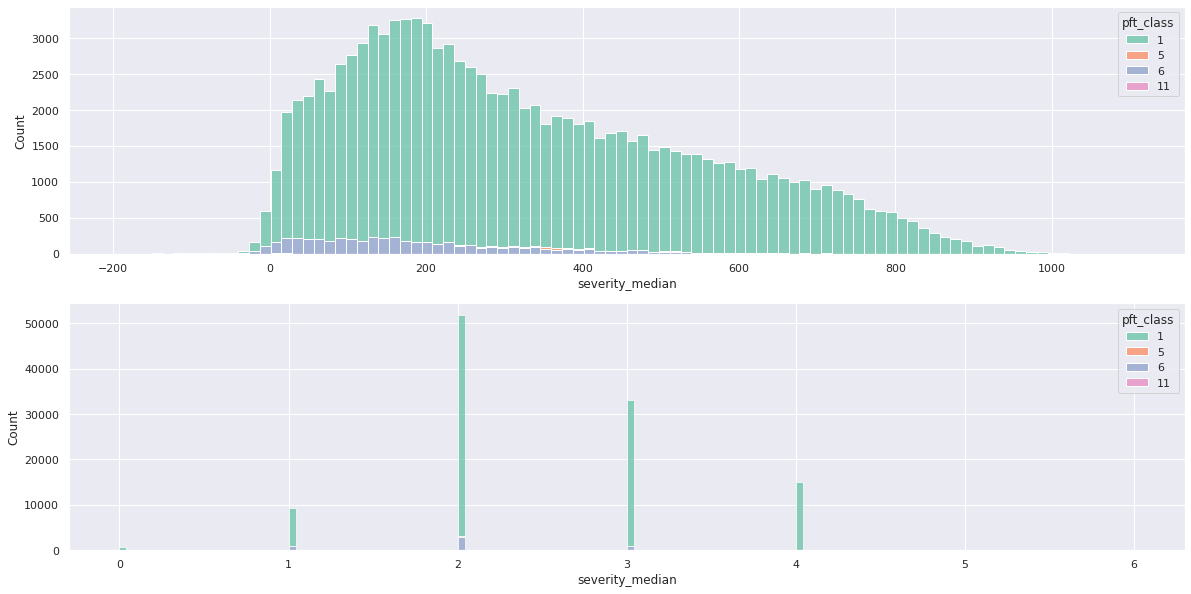

In [59]:
fig, ax = plt.subplots(2, 1, figsize=(20,10))
sns.histplot(gedi_dnbr, x='severity_median', ax=ax[0], hue='pft_class', multiple='stack', palette='Set2')
sns.histplot(gedi_dnbr6, x='severity_median', ax=ax[1], hue='pft_class', multiple='stack', palette='Set2')

<AxesSubplot: >

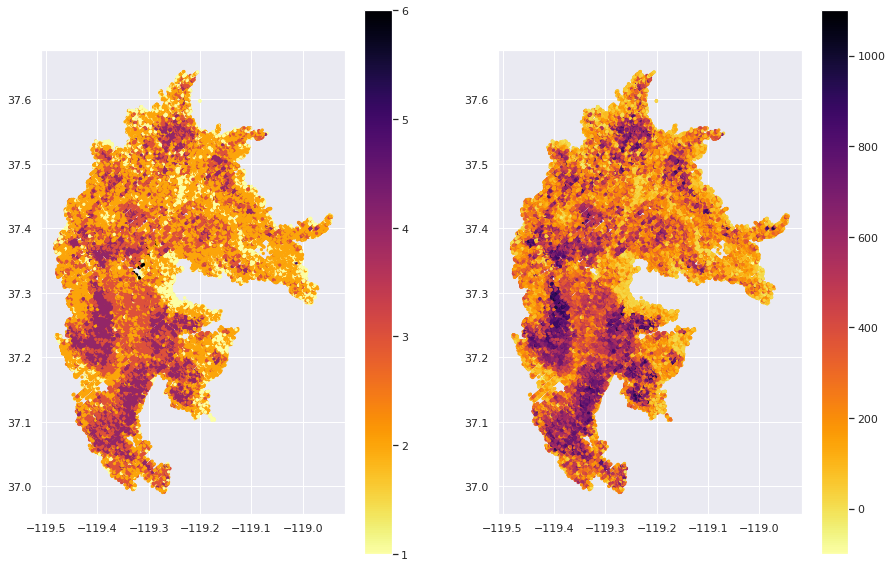

In [34]:
fig, ax = plt.subplots(1, 2, figsize=(15,10))

gedi_dnbr6.plot(column='severity_median', ax=ax[0], legend=True, vmin=1, vmax=6, markersize=5, cmap='inferno_r')
gedi_dnbr.plot(column='severity_median', ax=ax[1], legend=True, vmin=-50, vmax=1100, markersize=5, cmap='inferno_r')

### Look at GEDI outliers - i.e. high values

In [91]:
gedi_dnbr[gedi_dnbr.agbd > 1000]

shot_number                     absolute_time  lon_lowestmode  \
12165    87140300200119742  2020-06-26 13:14:34.371534+01:00     -119.138257   
12571   222621100300286209  2022-11-17 09:32:45.694144+00:00     -119.181710   
26976   175890800200123658  2022-01-20 01:46:09.409000+00:00     -119.296725   
30647    21830200200229561  2019-05-02 11:57:51.793781+01:00     -119.329107   
43765   175891100200120018  2022-01-20 01:46:09.239588+00:00     -119.299293   
58641   138880600300528397  2021-05-26 08:14:45.707926+01:00     -119.117106   
73189    87140500200119808  2020-06-26 13:14:34.991334+01:00     -119.117775   
88382    87140300200119608  2020-06-26 13:14:33.264102+01:00     -119.203641   
105735  140101100300286998  2021-06-03 05:09:19.389124+01:00     -119.221711   
117790   87140800200123128  2020-06-26 13:14:32.970675+01:00     -119.245299   
151609  140710800300290278  2021-06-07 03:36:33.030732+01:00     -119.273817   
153501  174560100300289839  2022-01-11 12:15:09.706599+00:00     -119.309235   
196691  140100800300288201  2021-06-03 05:09:19.104016+01:00     -119.237471   
205229  175891100200120019  2022-01-20 01:46:09.247852+00:00     -119.298805   

        lat_lowestmode         agbd  agbd_pi_lower  agbd_pi_upper    agbd_se  \
12165        37.541564  1050.158081     836.717712    1287.820190   4.381495   
12571        37.527129  2341.169189    1949.939087    2768.142822   6.465720   
26976        37.256257  1509.045654    1110.326050    1968.814087  11.271598   
30647        37.246484  1475.666504    1081.766968    1930.598877  11.268719   
43765        37.247141  1313.136475     943.685669    1743.478638  11.242555   
58641        37.543376  2191.876709    1702.715942    2742.720947  11.388708   
73189        37.547275  1047.258057     720.004944    1435.638794  11.286198   
88382        37.496661  1274.651001    1029.418091    1546.059692   4.734939   
105735       37.446379  1277.323608     913.308899    1702.249634  11.246241   
117790       37.444168  1100.885986     765.639343    1496.839966  11.208571   
151609       37.403068  1074.776489     857.814331    1316.173096   4.419974   
153501       37.336844  1000.508911     682.486877    1379.171265  11.196203   
196691       37.464271  2680.233887    2243.322266    3155.992920   7.027194   
205229       37.247479  1416.119141    1031.046387    1862.164673  11.257600   

       beam_type  sensitivity  pft_class                     geometry  \
12165   coverage     0.951421          6  POINT (-119.13826 37.54156)   
12571       full     0.975249          6  POINT (-119.18171 37.52713)   
26976       full     0.985050          1  POINT (-119.29673 37.25626)   
30647   coverage     0.967763          1  POINT (-119.32911 37.24648)   
43765       full     0.977031          1  POINT (-119.29929 37.24714)   
58641       full     0.964331          1  POINT (-119.11711 37.54338)   
73189       full     0.980088          1  POINT (-119.11778 37.54728)   
88382   coverage     0.955434          6  POINT (-119.20364 37.49666)   
105735      full     0.959217          1  POINT (-119.22171 37.44638)   
117790      full     0.962980          1  POINT (-119.24530 37.44417)   
151609      full     0.969577          6  POINT (-119.27382 37.40307)   
153501  coverage     0.957749          1  POINT (-119.30923 37.33684)   
196691      full     0.951657          6  POINT (-119.23747 37.46427)   
205229      full     0.981893          1  POINT (-119.29881 37.24748)   

                                         severity_3x3  severity_sample  \
12165     [107, 396, 407, 94, 396, 433, 68, 312, 429]              396   
12571      [0, 158, 313, 163, -13, 273, 166, 106, 98]              -13   
26976   [421, 323, 319, 421, 323, 375, 367, 383, 366]              323   
30647   [277, 197, 137, 168, 126, 206, 145, 229, 257]              126   
43765   [371, 349, 369, 440, 368, 447, 391, 399, 523]              368   
58641        [146, 214, 313, 76, 0, 313, 67, 10, 143]                0   

<AxesSubplot: >

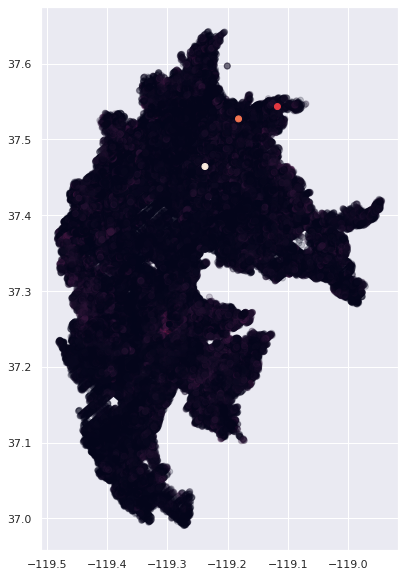

In [95]:
fig, ax = plt.subplots(1, 1, figsize=(15,10))

gedi_dnbr.plot(column='agbd', ax=ax, alpha=0.2)
gedi_dnbr[gedi_dnbr.agbd > 1500].plot(column='agbd', ax=ax)

### Look at GEDI before and after fire

In [97]:
print('AGBD before fire')
print(gedi_dnbr_before.agbd.describe())

print('AGBD after fire')
print(gedi_dnbr_after.agbd.describe())

AGBD before fire
count    42454.000000
mean       115.205988
std        106.792929
min          1.061925
25%         40.437689
50%         80.680099
75%        153.143761
max       1475.666504
Name: agbd, dtype: float64
AGBD after fire
count    67561.000000
mean        84.938165
std         93.600261
min          0.870713
25%         26.795208
50%         52.248116
75%        104.708260
max       2680.233887
Name: agbd, dtype: float64


(0.0, 700.0)

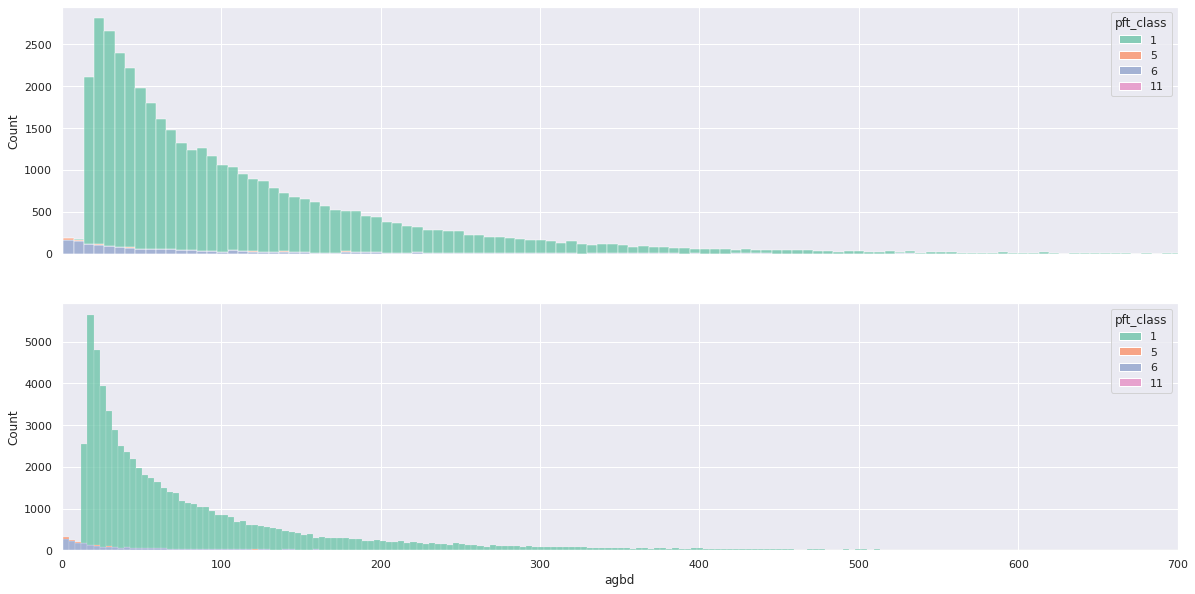

In [51]:
fig, ax = plt.subplots(2, 1, figsize=(20,10), sharex=True)
sns.histplot(gedi_dnbr_before, x='agbd', ax=ax[0], hue='pft_class', multiple='stack', palette='Set2')
g = sns.histplot(gedi_dnbr_after, x='agbd', ax=ax[1], hue='pft_class', multiple='stack', palette='Set2')
ax[1].set_xlim((0, 700))

(0.0, 700.0)

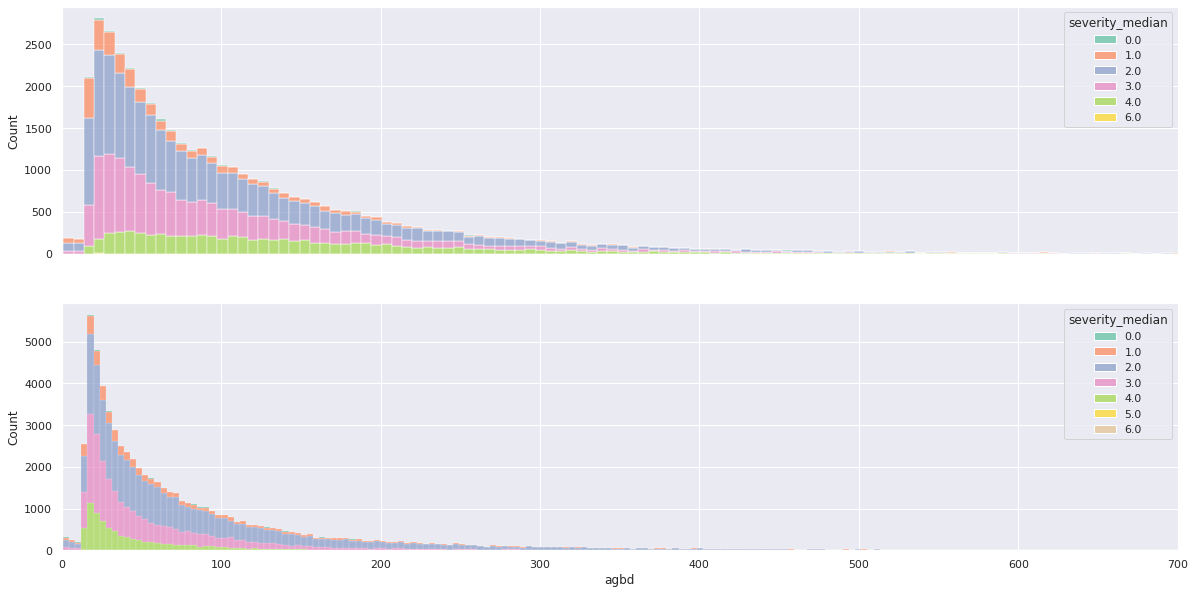

In [53]:
fig, ax = plt.subplots(2, 1, figsize=(20,10), sharex=True)
sns.histplot(gedi_dnbr6_before, x='agbd', ax=ax[0], hue='severity_median', multiple='stack', palette='Set2')
g = sns.histplot(gedi_dnbr6_after, x='agbd', ax=ax[1], hue='severity_median', multiple='stack', palette='Set2')
ax[1].set_xlim((0, 700))

<AxesSubplot: xlabel='agbd', ylabel='severity_median'>

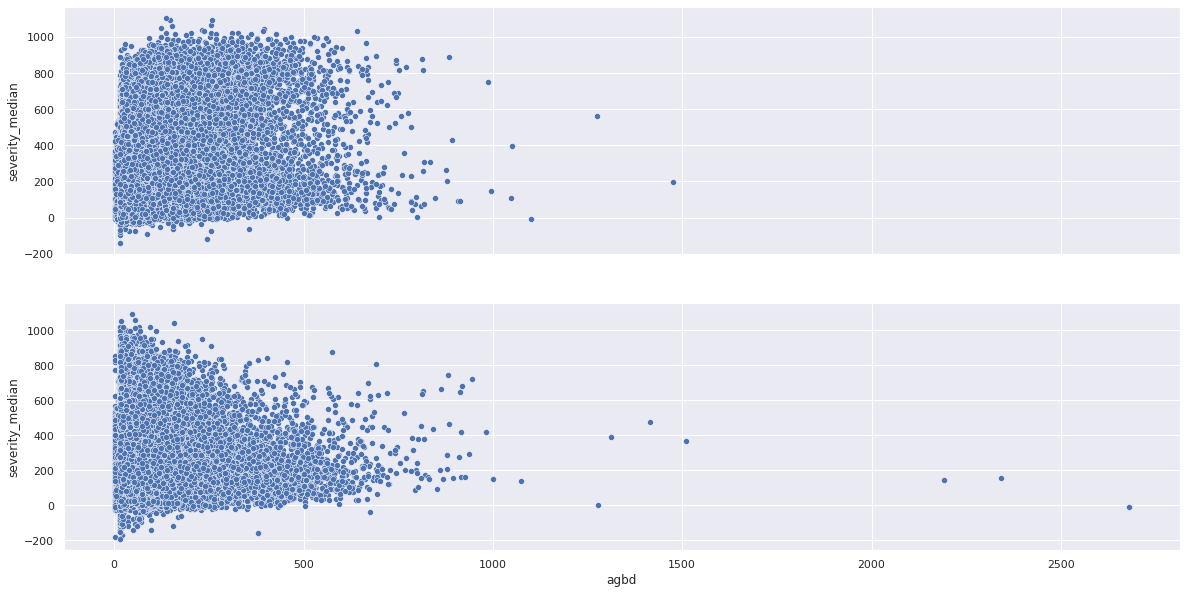

In [61]:
fig, ax = plt.subplots(2, 1, figsize=(20,10), sharex=True)
sns.scatterplot(gedi_dnbr_before, x='agbd', y='severity_median', ax=ax[0])
sns.scatterplot(gedi_dnbr_after, x='agbd', y='severity_median', ax=ax[1])

<AxesSubplot: xlabel='agbd', ylabel='severity_median'>

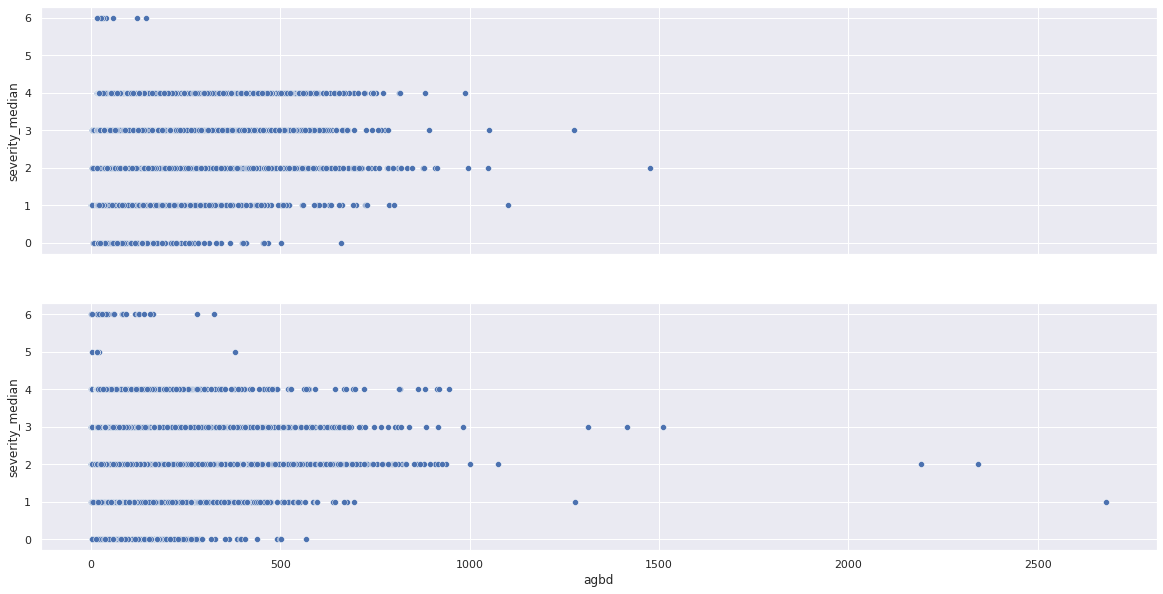

In [83]:
fig, ax = plt.subplots(2, 1, figsize=(20,10), sharex=True)
sns.scatterplot(gedi_dnbr6_before, x='agbd', y='severity_median', ax=ax[0])
sns.scatterplot(gedi_dnbr6_after, x='agbd', y='severity_median', ax=ax[1])

<AxesSubplot: xlabel='severity_median', ylabel='Count'>

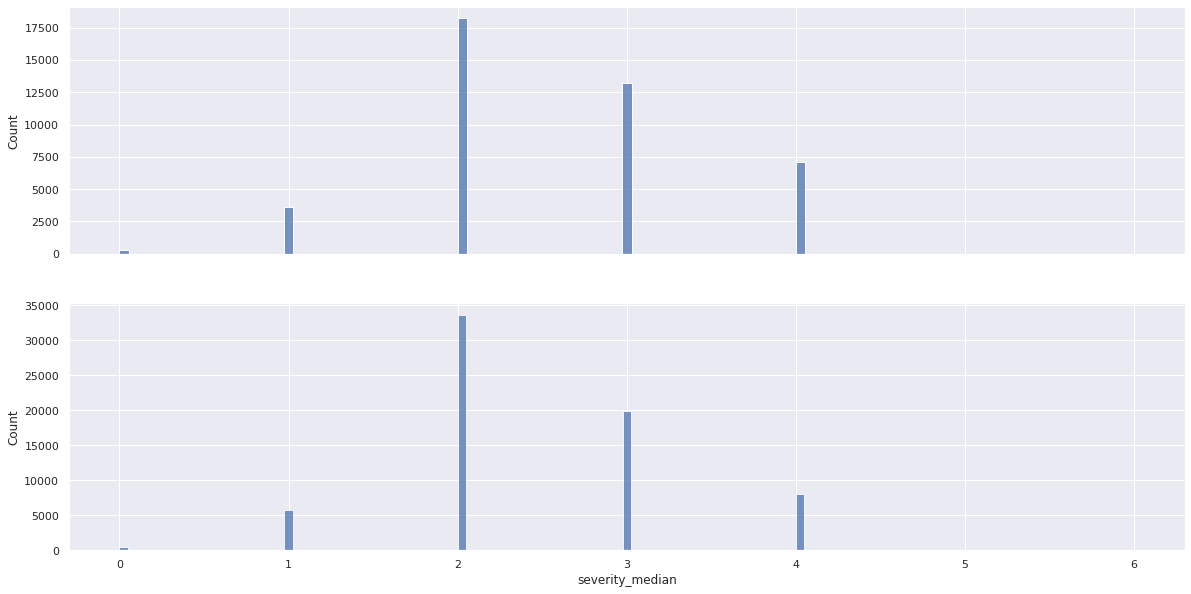

In [84]:
fig, ax = plt.subplots(2, 1, figsize=(20,10), sharex=True)
sns.histplot(gedi_dnbr6_before, x='severity_median', ax=ax[0])
sns.histplot(gedi_dnbr6_after, x='severity_median', ax=ax[1])

<AxesSubplot: >

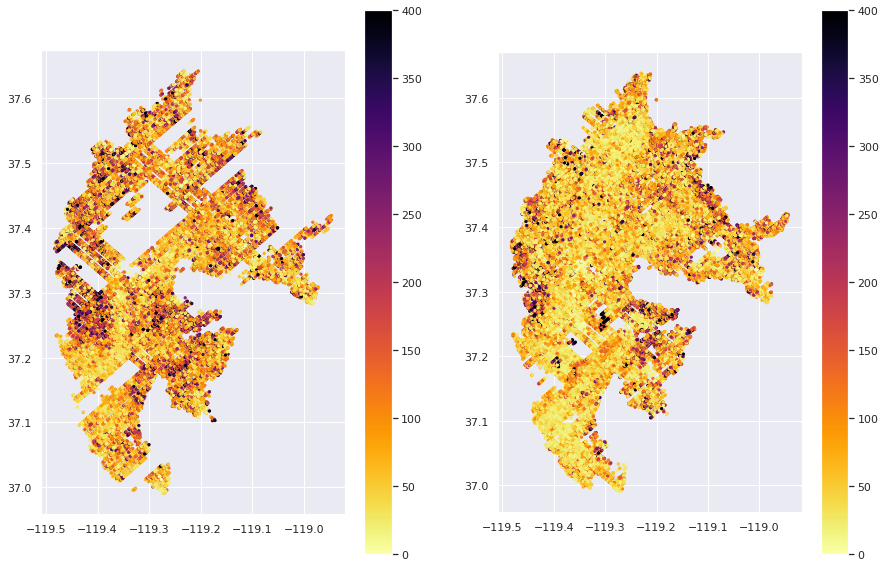

In [69]:
fig, ax = plt.subplots(1, 2, figsize=(15,10))

gedi_dnbr_before.plot(column='agbd', ax=ax[0], legend=True, vmin=0, vmax=400, markersize=5, cmap='inferno_r')
gedi_dnbr_after.plot(column='agbd', ax=ax[1], legend=True, vmin=0, vmax=400, markersize=5, cmap='inferno_r')

### Look at unburned buffer zone GEDI before and after fire

In [65]:
print('AGBD before fire')
print(gedi_buffer_dnbr_before.agbd.describe())

print('AGBD after fire')
print(gedi_buffer_dnbr_after.agbd.describe())

AGBD before fire
count    57503.000000
mean       106.045784
std        103.552680
min          0.776436
25%         34.581120
50%         71.073746
75%        143.698608
max       1305.674316
Name: agbd, dtype: float64
AGBD after fire
count    104627.000000
mean         94.441961
std          97.104075
min           0.834731
25%          30.557607
50%          63.248981
75%         126.156799
max        2363.856201
Name: agbd, dtype: float64


In [79]:
print('AGBD before fire')
print(gedi_buffer_dnbr_before[gedi_buffer_dnbr_before.pft_class==1].agbd.describe())

print('AGBD after fire')
print(gedi_buffer_dnbr_after[gedi_buffer_dnbr_after.pft_class==1].agbd.describe())

AGBD before fire
count    45789.000000
mean       114.342584
std        104.084847
min         12.965409
25%         40.924198
50%         79.815712
75%        152.887177
max        986.387390
Name: agbd, dtype: float64
AGBD after fire
count    75983.000000
mean       103.195589
std         94.236165
min         11.694054
25%         39.496864
50%         73.350754
75%        135.357971
max       2363.856201
Name: agbd, dtype: float64


(0.0, 700.0)

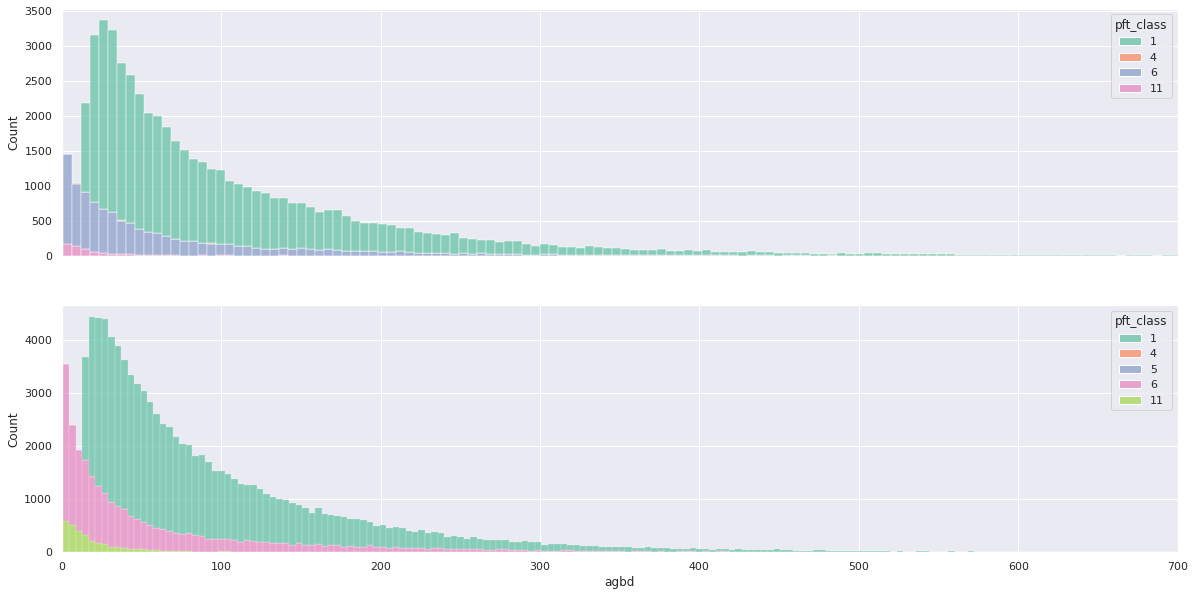

In [76]:
fig, ax = plt.subplots(2, 1, figsize=(20,10), sharex=True)
sns.histplot(gedi_buffer_dnbr_before, x='agbd', ax=ax[0], hue='pft_class', multiple='stack', palette='Set2')
g = sns.histplot(gedi_buffer_dnbr_after, x='agbd', ax=ax[1], hue='pft_class', multiple='stack', palette='Set2')
ax[1].set_xlim((0, 700))

<AxesSubplot: xlabel='agbd', ylabel='severity_median'>

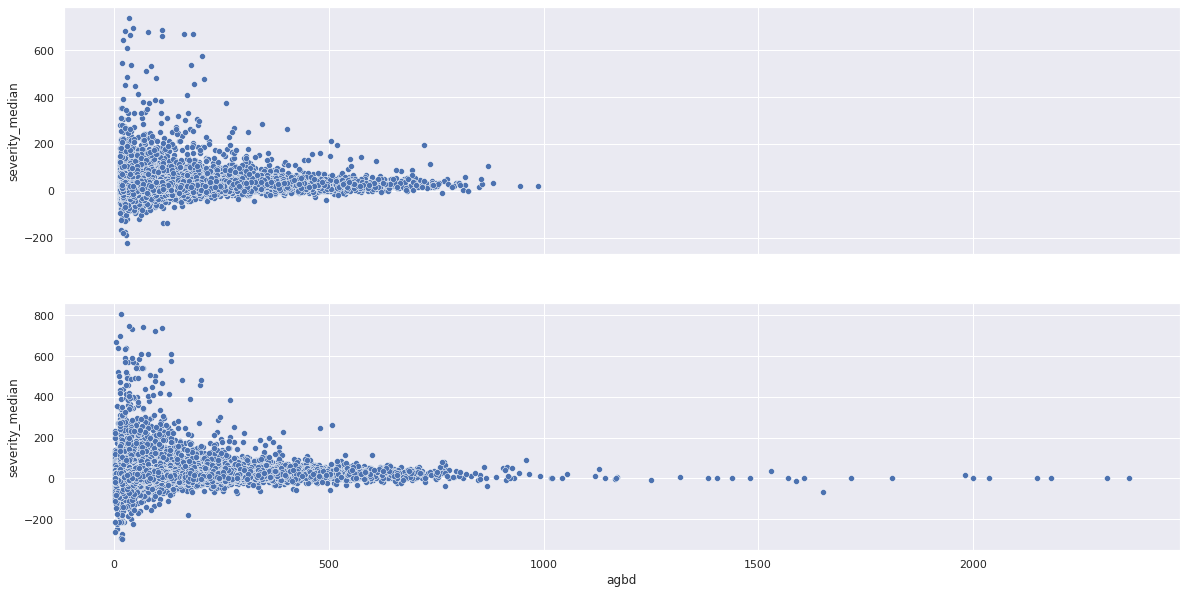

In [86]:
fig, ax = plt.subplots(2, 1, figsize=(20,10), sharex=True)
sns.scatterplot(gedi_buffer_dnbr_before[gedi_buffer_dnbr_before.pft_class==1], x='agbd', y='severity_median', ax=ax[0])
sns.scatterplot(gedi_buffer_dnbr_after, x='agbd', y='severity_median', ax=ax[1])

<AxesSubplot: xlabel='agbd', ylabel='severity_median'>

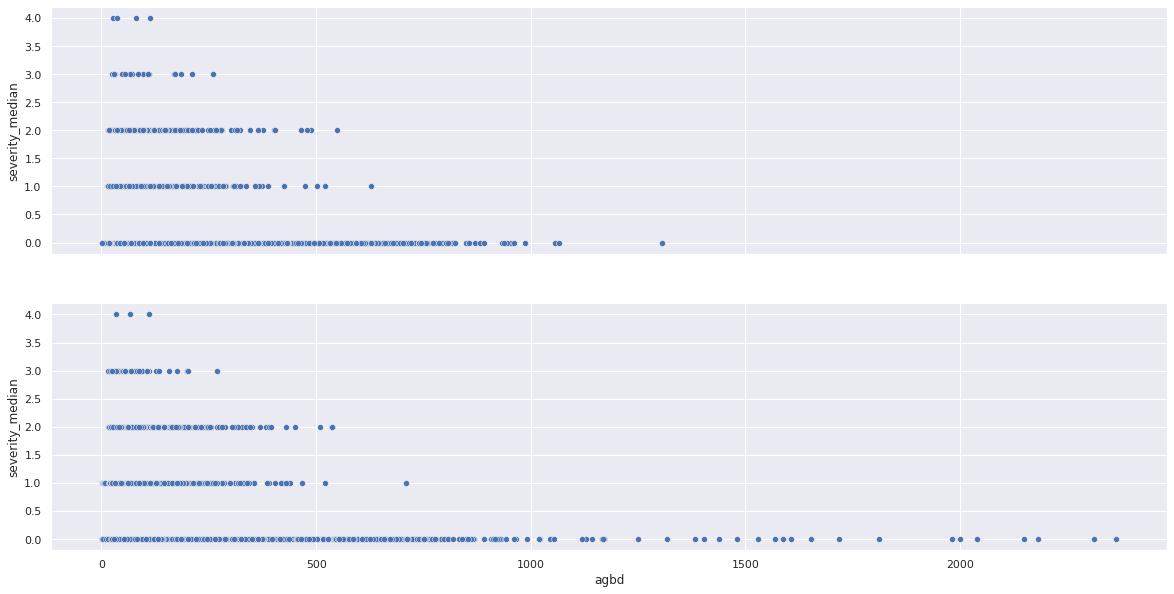

In [82]:
fig, ax = plt.subplots(2, 1, figsize=(20,10), sharex=True)
sns.scatterplot(gedi_buffer_dnbr6_before, x='agbd', y='severity_median', ax=ax[0])
sns.scatterplot(gedi_buffer_dnbr6_after, x='agbd', y='severity_median', ax=ax[1])

<AxesSubplot: xlabel='severity_median', ylabel='Count'>

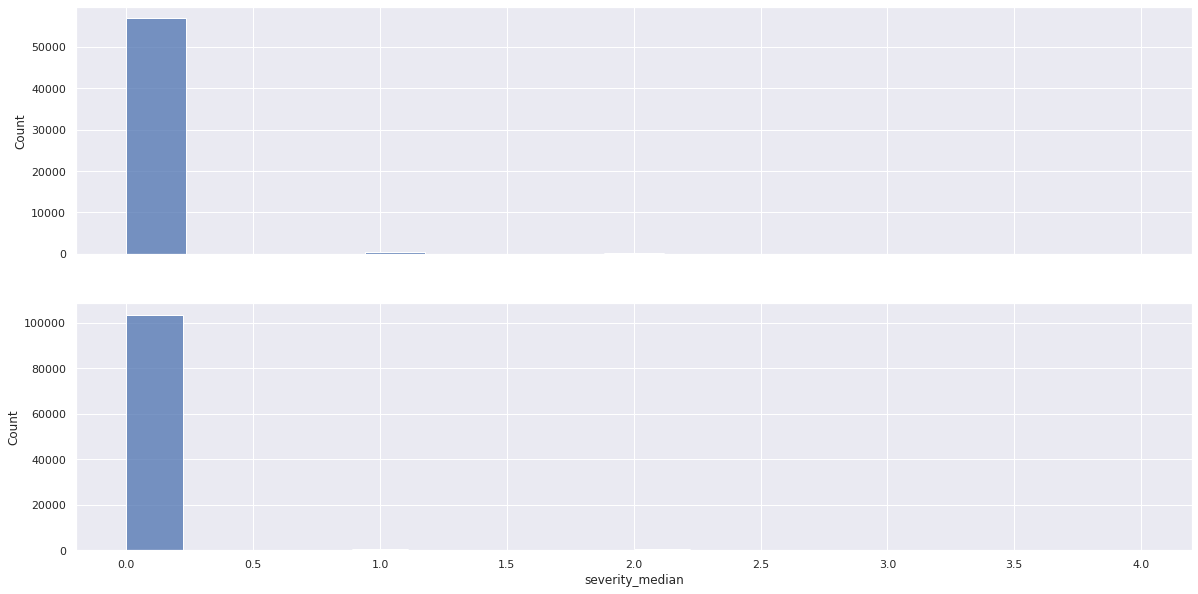

In [85]:
fig, ax = plt.subplots(2, 1, figsize=(20,10), sharex=True)
sns.histplot(gedi_buffer_dnbr6_before, x='severity_median', ax=ax[0])
sns.histplot(gedi_buffer_dnbr6_after, x='severity_median', ax=ax[1])

<AxesSubplot: >

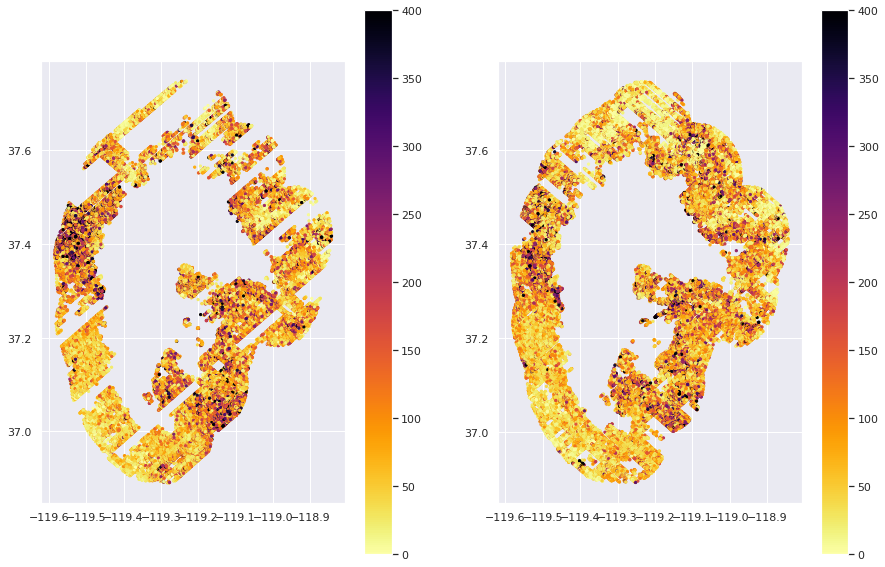

In [98]:
fig, ax = plt.subplots(1, 2, figsize=(15,10))

gedi_buffer_dnbr_before.plot(column='agbd', ax=ax[0], legend=True, vmin=0, vmax=400, markersize=5, cmap='inferno_r')
gedi_buffer_dnbr_after.plot(column='agbd', ax=ax[1], legend=True, vmin=0, vmax=400, markersize=5, cmap='inferno_r')

In [ ]:
# Let's look at per pft class
fig, ax = plt.subplots(2, 1, figsize=(20,10), sharex=True)
sns.histplot(gedi_dnbr_before, x='agbd', ax=ax[0], hue='pft')
g = sns.histplot(gedi_dnbr_after, x='agbd', ax=ax[1])
ax[1].set_xlim((0, 700))

<AxesSubplot: >

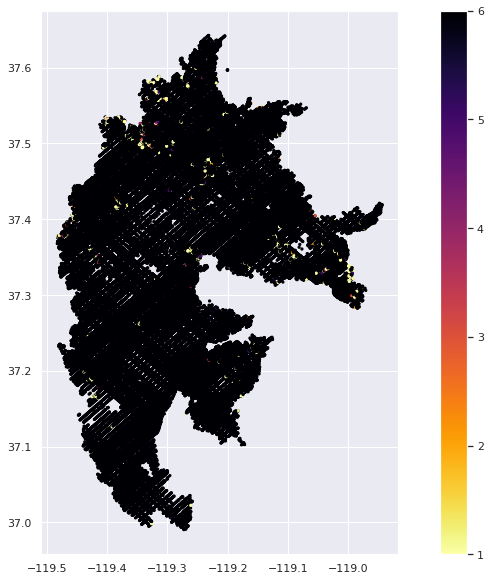

In [53]:
fig, ax = plt.subplots(1, 2, figsize=(15,10))

gedi_dnbr_before.plot(column='agbd', ax=ax[0], legend=True, vmin=1, vmax=6, markersize=5, cmap='inferno_r')
gedi_dnbr.plot(column='severity_median', ax=ax[1], legend=True, vmin=-50, vmax=1100, markersize=5, cmap='inferno_r')

<AxesSubplot: >

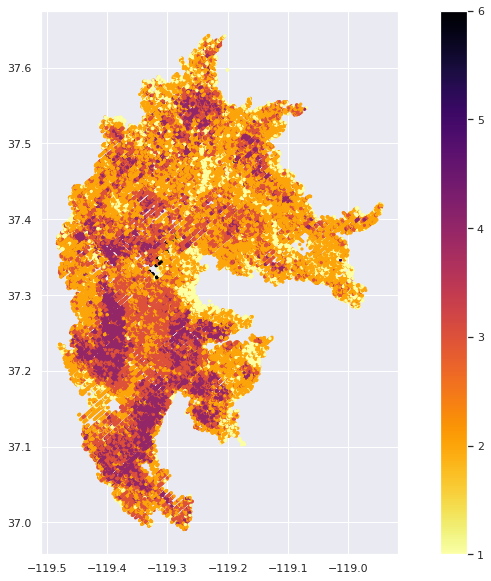

In [129]:
fig, ax = plt.subplots(figsize=(15,10))

gedi_dnbr6.plot(column='severity_median', ax=ax, legend=True, vmin=1, vmax=6, markersize=5, cmap='inferno_r')

<AxesSubplot: >

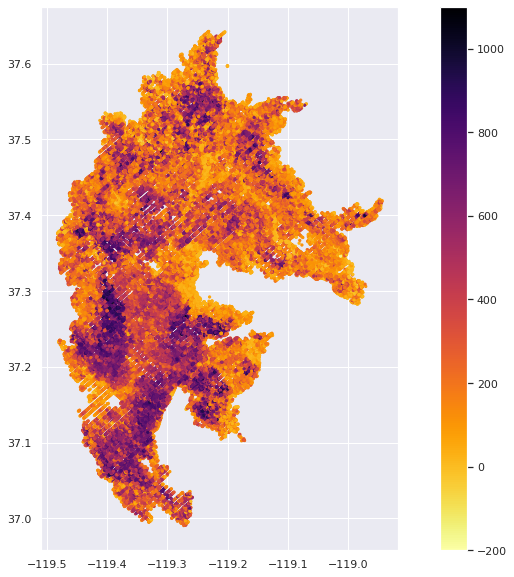

In [164]:
fig, ax = plt.subplots(figsize=(15,10))

gedi_dnbr_match.plot(column='severity_median', ax=ax, legend=True, vmin=-200, vmax=1100, markersize=5, cmap='inferno_r')

In [19]:
# Get only GEDI before the fire
gedi_dnbr6_before = gedi_dnbr6[gedi_dnbr6.absolute_time < creek.get_alarm_date()]
gedi_dnbr6_after = gedi_dnbr6[gedi_dnbr6.absolute_time < creek.get_cont_date()]

NameError: name 'gedi_dnbr6' is not defined

In [165]:
# Get only GEDI before the fire
gedi_dnbr_match_before = gedi_dnbr_match[gedi_dnbr6_match.absolute_time < alarm_date]
gedi_dnbr_match_after = gedi_dnbr_match[gedi_dnbr6_match.absolute_time < cont_date]

<AxesSubplot: xlabel='agbd', ylabel='severity_median'>

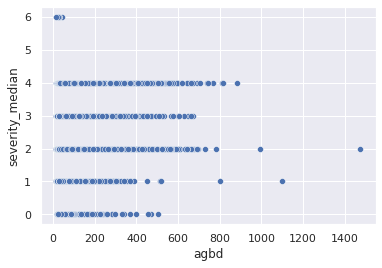

In [144]:
gedi_fitlered = gedi_dnbr6_match_before[(gedi_dnbr6_match_before.pft_class==1) & (gedi_dnbr6_match_before.severity_std==0)]
sns.scatterplot(gedi_fitlered, x='agbd', y='severity_median')

<AxesSubplot: xlabel='agbd', ylabel='severity_median'>

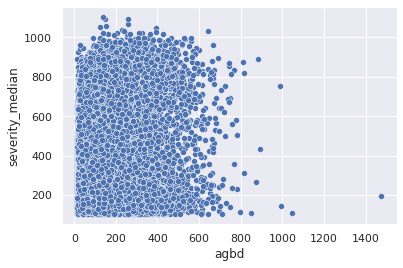

In [177]:
gedi_fitlered = gedi_dnbr_match_before[(gedi_dnbr_match_before.pft_class==1)&(gedi_dnbr_match_before.severity_median > 100)]#&(gedi_dnbr_match_before.severity_std < 50)]
sns.scatterplot(gedi_fitlered, x='agbd', y='severity_median')

In [169]:
gedi_fitlered[gedi_fitlered.severity_std < 50]

shot_number                     absolute_time  lon_lowestmode  \
39      88970500200080811  2020-07-08 08:31:34.626648+01:00     -119.063543   
131     88970300200081100  2020-07-08 08:31:36.254758+01:00     -118.951901   
133     88970300200081105  2020-07-08 08:31:36.296078+01:00     -118.949450   
200     42640500300289600  2019-09-13 13:53:30.122725+01:00     -119.282066   
203     42640500300289618  2019-09-13 13:53:30.271477+01:00     -119.273360   
...                   ...                               ...             ...   
229712  22790100300216532  2019-05-08 16:35:55.991316+01:00     -119.375107   
229873  22790200300230280  2019-05-08 16:35:55.028504+01:00     -119.419320   
229875  22790200300230282  2019-05-08 16:35:55.045032+01:00     -119.418328   
229888  22790300300216425  2019-05-08 16:35:54.916940+01:00     -119.427184   
229889  22790300300216426  2019-05-08 16:35:54.925204+01:00     -119.426690   

        lat_lowestmode        agbd  agbd_pi_lower  agbd_pi_upper    agbd_se  \
39           37.322730   54.071041       3.438805     165.179077  11.165835   
131          37.408212   47.138588       1.899059     152.607605  11.120360   
133          37.409905  355.034241     178.392487     591.868103  11.113459   
200          37.186070   26.954811   -9999.000000     113.984283  11.107595   
203          37.180059  172.985062      58.392567     348.317047  11.214524   
...                ...         ...            ...            ...        ...   
229712       37.362808   88.941498      15.588778     222.412369  11.099806   
229873       37.388177  468.100311     260.245758     736.531799  11.184494   
229875       37.387497  126.172050      33.055866     279.419434  11.102211   
229888       37.386516  496.112640     281.694672     770.806885  11.129007   
229889       37.386177   34.543156       0.154073     129.098755  11.108734   

       beam_type  sensitivity  pft_class                     geometry  \
39          full     0.963817          1  POINT (-119.06354 37.32273)   
131     coverage     0.970255          1  POINT (-118.95190 37.40821)   
133     coverage     0.975826          1  POINT (-118.94945 37.40991)   
200         full     0.988946          1  POINT (-119.28207 37.18607)   
203         full     0.986560          1  POINT (-119.27336 37.18006)   
...          ...          ...        ...                          ...   
229712  coverage     0.964888          1  POINT (-119.37511 37.36281)   
229873  coverage     0.970615          1  POINT (-119.41932 37.38818)   
229875  coverage     0.968013          1  POINT (-119.41833 37.38750)   
229888  coverage     0.974600          1  POINT (-119.42718 37.38652)   
229889  coverage     0.963801          1  POINT (-119.42669 37.38618)   

                                         severity_3x3  severity_sample  \
39      [155, 155, 146, 188, 132, 193, 160, 236, 237]              132   
131     [149, 224, 222, 149, 186, 222, 165, 169, 134]              186   
133     [187, 268, 186, 181, 178, 186, 159, 149, 200]              178   
200     [618, 639, 676, 600, 708, 670, 691, 649, 679]              708   
203     [584, 631, 725, 655, 600, 662, 657, 649, 608]              600   
...                                               ...              ...   
229712  [622, 549, 549, 622, 608, 539, 638, 552, 603]              608   
229873  [315, 315, 288, 327, 281, 371, 429, 281, 270]              281   
229875  [336, 431, 459, 428, 442, 450, 447, 358, 378]              442   
229888  [597, 655, 578, 533, 646, 594, 615, 640, 594]              646   
229889  [646, 594, 543, 640, 594, 605, 687, 563, 526]              594   

        severity_mean  severity_std  severity_median  
39         178.000000     36.043184            160.0  
131        180.000000     33.139436            169.0  
133        188.222222     31.734236            186.0  
200        658.888889     33.161036            670.0  
203        641.222222     39.625406            649.0  
...               ..

<AxesSubplot: >

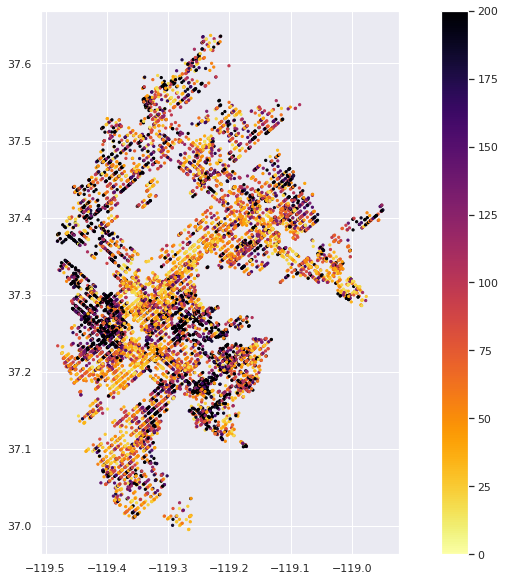

In [146]:
fig, ax = plt.subplots(figsize=(15,10))

gedi_fitlered.plot(column='agbd', ax=ax, legend=True, vmin=0, vmax=200, markersize=5, cmap='inferno_r')

In [178]:
gedi_fitlered.corr()

/tmp/ipykernel_3982949/1874693470.py:1: FutureWarning: The default value of numeric_only in GeoDataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  gedi_fitlered.corr()


shot_number  lon_lowestmode  lat_lowestmode      agbd  \
shot_number         1.000000        0.136978       -0.174382 -0.030331   
lon_lowestmode      0.136978        1.000000        0.222626 -0.049919   
lat_lowestmode     -0.174382        0.222626        1.000000  0.038008   
agbd               -0.030331       -0.049919        0.038008  1.000000   
agbd_pi_lower       0.021270        0.005717        0.045503  0.368223   
agbd_pi_upper      -0.027762       -0.047146        0.040894  0.997380   
agbd_se            -0.046227        0.061701        0.096148  0.234329   
sensitivity         0.038811       -0.084106       -0.119557  0.166572   
pft_class                NaN             NaN             NaN       NaN   
severity_sample     0.038760       -0.249409       -0.258105  0.143923   
severity_mean       0.040278       -0.275197       -0.282042  0.144647   
severity_std       -0.013634        0.052012        0.041094 -0.002099   
severity_median     0.039280       -0.270662       -0.279286  0.143630   

                 agbd_pi_lower  agbd_pi_upper   agbd_se  sensitivity  \
shot_number           0.021270      -0.027762 -0.046227     0.038811   
lon_lowestmode        0.005717      -0.047146  0.061701    -0.084106   
lat_lowestmode        0.045503       0.040894  0.096148    -0.119557   
agbd                  0.368223       0.997380  0.234329     0.166572   
agbd_pi_lower         1.000000       0.407895  0.157496     0.166679   
agbd_pi_upper         0.407895       1.000000  0.243800     0.175197   
agbd_se               0.157496       0.243800  1.000000     0.057849   
sensitivity           0.166679       0.175197  0.057849     1.000000   
pft_class                  NaN            NaN       NaN          NaN   
severity_sample       0.118745       0.149881 -0.010643     0.115680   
severity_mean         0.111399       0.149853 -0.012965     0.115017   
severity_std          0.006013      -0.001520 -0.006177    -0.030922   
severity_median       0.111887       0.148960 -0.012253     0.115358   

                 pft_class  severity_sample  severity_mean  severity_std  \
shot_number            NaN         0.038760       0.040278     -0.013634   
lon_lowestmode         NaN        -0.249409      -0.275197      0.052012   
lat_lowestmode         NaN        -0.258105      -0.282042      0.041094   
agbd                   NaN         0.143923       0.144647     -0.002099   
agbd_pi_lower          NaN         0.118745       0.111399      0.006013   
agbd_pi_upper          NaN         0.149881       0.149853     -0.001520   
agbd_se                NaN        -0.010643      -0.012965     -0.006177   
sensitivity            NaN         0.115680       0.115017     -0.030922   
pft_class              NaN              NaN            NaN           NaN   
severity_sample        NaN         1.000000       0.951548      0.111122   
severity_mean          NaN         0.951548       1.000000      0.111477   
severity_std           NaN         0.111122       0.111477      1.000000   
severity_median        NaN         0.952931       0.991431      0.108123   

                 severity_median  
shot_number             0.039280  
lon_lowestmode         -0.270662  
lat_lowestmode         -0.279286  
agbd                    0.143630  
agbd_pi_lower           0.111887  
agbd_pi_upper           0.148960  
agbd_se                -0.012253  
sensitivity             0.115358  
pft_class                    NaN  
severity_sample         0.952931  
severity_mean           0.991431  
severity_std            0.108123  
severity_median         1.000000

In [ ]:
fig, ax = plt.subplots(figsize=(15,10))

gedi_dnbr6_match.plot(column='severity_median', ax=ax, legend=True, vmin=1, vmax=6, markersize=5, cmap='inferno_r')

In [98]:
raster_t = rio.open('/maps/fire-regen/data/rasters/CREEK/creek_dnbr6.tiff')

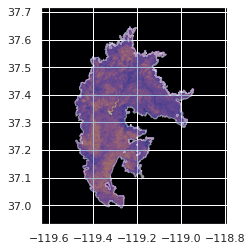

In [102]:
from rasterio.plot import show as show_raster
f, ax = plt.subplots()

show_raster((raster_t, 1), ax=ax, cmap='inferno')
#raster_test_reprojected.plot.imshow(ax=ax, cmap="inferno", vmin=0, vmax=5)
#plt.imshow(raster_test.read(1), cmap='pink', ax=ax)
creek.plot(ax=ax, alpha=0.5)

plt.show()

In [68]:
creek.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [ ]:
from src.data import sample_raster
# 1. MTBS severity mosaic
mtbs_mosaic = sample_raster


In [12]:
severity = mtbs.get_burn_severity_data_for_year(2020)

In [15]:
from src.data import shape_processor
ee_viz.viz_burn_severity(severity, shape_processor.get_convex_hull(creek.geometry).geometry.iloc[0], ['burn_severity'])

{'max': {'burn_severity': 6, 'burn_year': 2020}, 'mean': {'burn_severity': 2.524398022006092, 'burn_year': 2020}, 'min': {'burn_severity': 1, 'burn_year': 2020}, 'std': {'burn_severity': 0.9053070636083459, 'burn_year': 0}, 'sum': {'burn_severity': 4356041.6509803925, 'burn_year': 3485664328}}


Map(center=[37.3271746211198, -119.24194382373152], controls=(WidgetControl(options=['position', 'transparent_…

In [16]:
gedi_creek = gedi_loader.get_gedi_shots(creek.geometry)

2023-05-01 18:27:43,531 INFO: Loading Level 4a GEDI shots for period 2019-2023 in this geometry [in get_gedi_shots at /home/jk871/fire-regen/src/data/gedi_loader.py:20]
2023-05-01 18:28:15,089 INFO: Number of GEDI shots found: 110015 [in get_gedi_shots at /home/jk871/fire-regen/src/data/gedi_loader.py:58]


NameError: name 'creek_dixie' is not defined

In [18]:
gedi_creek = gpd.GeoDataFrame(gedi_creek, geometry=gpd.points_from_xy(gedi_creek.lon_lowestmode, gedi_creek.lat_lowestmode), crs=4326)

In [22]:
gedi_creek.columns

Index(['shot_number', 'absolute_time', 'lon_lowestmode', 'lat_lowestmode',
       'agbd', 'agbd_pi_lower', 'agbd_pi_upper', 'agbd_se', 'beam_type',
       'sensitivity', 'pft_class', 'geometry'],
      dtype='object')

In [29]:
creek

YEAR_ STATE AGENCY UNIT_ID FIRE_NAME   INC_NUM                 ALARM_DATE  \
241  2020    CA    USF     SNF     CREEK  00001391  2020-09-04T00:00:00+00:00   

                     CONT_DATE  CAUSE                              COMMENTS  \
241  2020-12-24T00:00:00+00:00   14.0  33CBB9DC-6983-4F47-B821-9C9A6CAC381D   

     ...  C_METHOD  OBJECTIVE  FIRE_NUM   Shape_Length    Shape_Area  \
241  ...       8.0        1.0      None  818087.845138  1.537168e+09   

     COMPLEX_NAME  COMPLEX_INCNUM  \
241          None            None   

                                              geometry index_right FID  
241  MULTIPOLYGON (((-119.18131 37.09620, -119.1813...           0   0  

[1 rows x 22 columns]

In [32]:
alarm_date = pd.to_datetime(creek.loc[241, 'ALARM_DATE'])

In [51]:
cont_date = pd.to_datetime(creek.loc[241, 'CONT_DATE'])

In [33]:
alarm_date

Timestamp('2020-09-04 00:00:00+0000', tz='UTC')

In [34]:
gedi_creek_before = gedi_creek[gedi_creek.absolute_time < alarm_date]

In [52]:
gedi_creek_after = gedi_creek[gedi_creek.absolute_time > cont_date]

In [37]:
gedi_creek_before[gedi_creek_before.pft_class==1]

shot_number                     absolute_time  lon_lowestmode  \
32      88970300200080846  2020-07-08 08:31:34.139063+01:00     -119.076509   
35      88970300200080851  2020-07-08 08:31:34.180383+01:00     -119.074045   
39      88970500200080811  2020-07-08 08:31:34.626648+01:00     -119.063543   
40      88970500200080812  2020-07-08 08:31:34.634914+01:00     -119.063055   
41      88970500200080815  2020-07-08 08:31:34.659712+01:00     -119.061597   
...                   ...                               ...             ...   
229887  22790300300216424  2019-05-08 16:35:54.908676+01:00     -119.427679   
229888  22790300300216425  2019-05-08 16:35:54.916940+01:00     -119.427184   
229889  22790300300216426  2019-05-08 16:35:54.925204+01:00     -119.426690   
229890  22790300300216427  2019-05-08 16:35:54.933468+01:00     -119.426195   
230000  22790500300216227  2019-05-08 16:35:54.784699+01:00     -119.461637   

        lat_lowestmode        agbd  agbd_pi_lower  agbd_pi_upper    agbd_se  \
32           37.322262  198.413193      73.988052     382.993256  11.106586   
35           37.323977   44.767944       1.457744     148.216003  11.103441   
39           37.322730   54.071041       3.438805     165.179077  11.165835   
40           37.323069  143.046692      41.937157     304.311859  11.106715   
41           37.324078   68.086197       7.575887     189.074600  11.166255   
...                ...         ...            ...            ...        ...   
229887       37.386855  126.496910      33.163212     280.074188  11.122966   
229888       37.386516  496.112640     281.694672     770.806885  11.129007   
229889       37.386177   34.543156       0.154073     129.098755  11.108734   
229890       37.385838   62.589233       5.853969     179.645065  11.137176   
230000       37.400117   22.677456   -9999.000000     104.993454  11.107620   

       beam_type  sensitivity  pft_class                     geometry  
32      coverage     0.973971          1  POINT (-119.07651 37.32226)  
35      coverage     0.975830          1  POINT (-119.07405 37.32398)  
39          full     0.963817          1  POINT (-119.06354 37.32273)  
40          full     0.989030          1  POINT (-119.06305 37.32307)  
41          full     0.971689          1  POINT (-119.06160 37.32408)  
...          ...          ...        ...                          ...  
229887  coverage     0.972174          1  POINT (-119.42768 37.38686)  
229888  coverage     0.974600          1  POINT (-119.42718 37.38652)  
229889  coverage     0.963801          1  POINT (-119.42669 37.38618)  
229890  coverage     0.980210          1  POINT (-119.42619 37.38584)  
230000      full     0.961019          1  POINT (-119.46164 37.40012)  

[40510 rows x 12 columns]

In [53]:
gedi_creek_after[gedi_creek_after.pft_class==1]

shot_number                     absolute_time  lon_lowestmode  \
0       154280500300290322  2021-09-02 16:59:13.930352+01:00     -119.073946   
1       154280500300290324  2021-09-02 16:59:13.946884+01:00     -119.072975   
2       154280500300290325  2021-09-02 16:59:13.955150+01:00     -119.072488   
3       154280500300290330  2021-09-02 16:59:13.996480+01:00     -119.070055   
5       154280600300527837  2021-09-02 16:59:13.917954+01:00     -119.076065   
...                    ...                               ...             ...   
229963  216780800200084783  2022-10-10 18:25:07.228367+01:00     -119.420800   
229964  216780800200084784  2022-10-10 18:25:07.236633+01:00     -119.420310   
229971  163690800200084240  2021-11-02 08:56:04.774172+00:00     -119.420768   
229983  138990100200119877  2021-05-27 00:56:27.074130+01:00     -119.415389   
229984  138990100200119878  2021-05-27 00:56:27.082394+01:00     -119.414900   

        lat_lowestmode        agbd  agbd_pi_lower  agbd_pi_upper    agbd_se  \
0            37.326553   40.928005       0.832434     141.196701  11.109954   
1            37.325882   73.325890       9.375071     197.802658  11.175099   
2            37.325545   38.910450       0.567278     137.416275  11.108020   
3            37.323864  216.127350      84.769859     407.857635  11.146821   
5            37.320751  196.798264      72.984306     380.791321  11.111056   
...                ...         ...            ...            ...        ...   
229963       37.388526   84.220932      13.536892     215.359772  11.161958   
229964       37.388862   73.634796       9.599105     197.793335  11.100669   
229971       37.388313  147.904694      44.574299     311.410095  11.110306   
229983       37.387338   44.198250       1.355944     147.183075  11.104300   
229984       37.387674   51.832397       2.943956     160.862259  11.104096   

       beam_type  sensitivity  pft_class                     geometry  
0           full     0.955587          1  POINT (-119.07395 37.32655)  
1           full     0.986906          1  POINT (-119.07298 37.32588)  
2           full     0.981586          1  POINT (-119.07249 37.32554)  
3           full     0.958319          1  POINT (-119.07005 37.32386)  
5           full     0.981729          1  POINT (-119.07606 37.32075)  
...          ...          ...        ...                          ...  
229963      full     0.959259          1  POINT (-119.42080 37.38853)  
229964      full     0.970735          1  POINT (-119.42031 37.38886)  
229971      full     0.955997          1  POINT (-119.42077 37.38831)  
229983  coverage     0.955121          1  POINT (-119.41539 37.38734)  
229984  coverage     0.952666          1  POINT (-119.41490 37.38767)  

[64316 rows x 12 columns]

<AxesSubplot: >

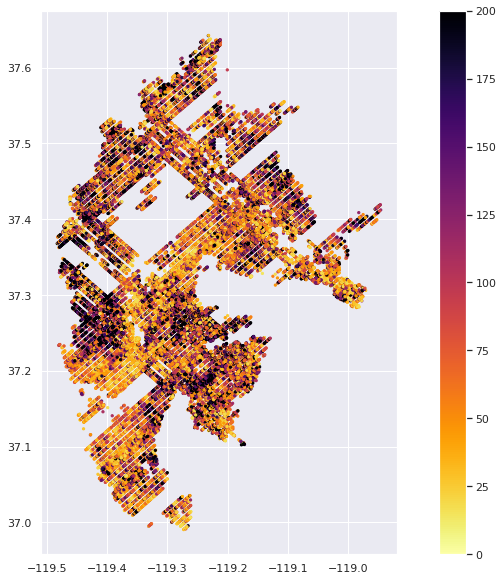

In [48]:
fig, ax = plt.subplots(figsize=(15,10))

gedi_creek_before[gedi_creek_before.pft_class==1].plot(column='agbd', ax=ax, legend=True, vmin=0, vmax=200, markersize=5, cmap='inferno_r')

<AxesSubplot: >

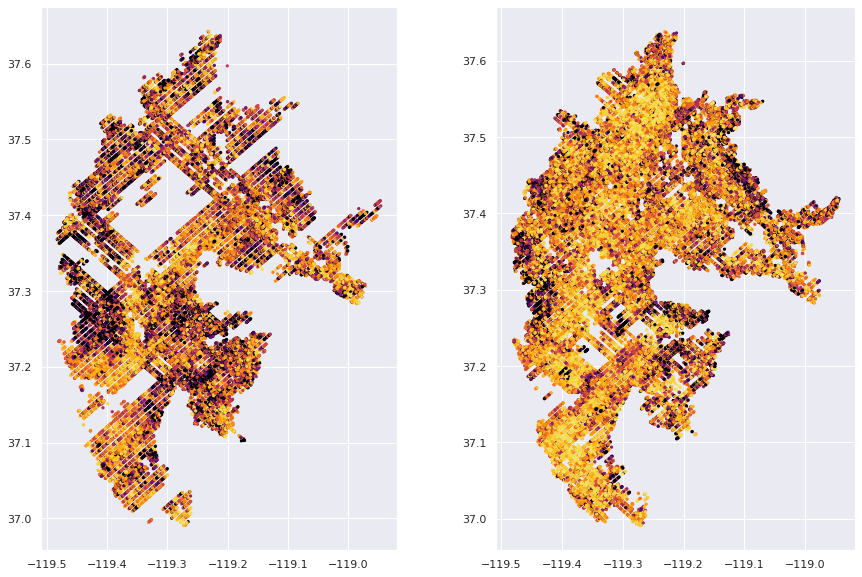

In [63]:
fig, ax = plt.subplots(1, 2, figsize=(15,10))

gedi_creek_before[gedi_creek_before.pft_class==1].plot(column='agbd', ax=ax[0], vmin=0, vmax=200, markersize=5, cmap='inferno_r')

gedi_creek_after[gedi_creek_after.pft_class==1].plot(column='agbd', ax=ax[1], legend=False, vmin=0, vmax=200, markersize=5, cmap='inferno_r')

## North Complex Fire

In [ ]:
north_complex = sierra_fire_perimeters[sierra_fire_perimeters.FIRE_NAME=='NORTH COMPLEX'].overlay(sierras, how="union")
north_complex.plot(cmap='tab20b')

In [ ]:
sierra_fire_perimeters[sierra_fire_perimeters.FIRE_NAME=='NORTH COMPLEX'].geometry.explore()

## Caldor Fire

In [ ]:
caldor = sierra_fire_perimeters[sierra_fire_perimeters.FIRE_NAME=='CALDOR'].overlay(sierras, how="union")
caldor.plot(cmap='tab20b')

In [ ]:
sierra_fire_perimeters[sierra_fire_perimeters.FIRE_NAME=='CALDOR'].geometry.explore()

## Castle Fire

In [ ]:
castle = sierra_fire_perimeters[sierra_fire_perimeters.FIRE_NAME=='CASTLE'].overlay(sierras, how="union")
castle.plot(cmap='tab20b')

In [ ]:
sierra_fire_perimeters[sierra_fire_perimeters.FIRE_NAME=='CASTLE'].geometry.explore()